# MultinomialNB on edit text; equivalent to VandalismScore

### Import packages

In [1]:
import sys
import os
import pandas as pd

# Automatically add the project root (1 level up) to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import preprocessor

In [2]:
from sklearn.model_selection import StratifiedKFold, TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin, _fit_context
from sklearn.pipeline import Pipeline, make_pipeline
import numpy as np

### Read training data and apply standard preprocessor

In [3]:
df = pd.read_csv(project_root+"/Data/train.csv")
preprocessor(df)

In [4]:
df.replace(np.nan, '', inplace=True)

### Make the MultinomialNB pipeline

Define the transformers needed:

In [21]:
class NaNToEmptyStr(TransformerMixin, BaseEstimator):
    """
    Replace all empty values in string columns with the empty string.
    """

    #_parameter_constraints = {"columns": [None, _ArrayLikes_(str)]}
    def __init__(self, columns=None):
        self.columns = columns

    #@_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.select_dtypes(include=object).columns
        self.is_fitted_ = True
        return self
    
    def transform(self, X):
        X_t = X.copy()
        X_t[self.columns] = X_t[self.columns].replace(np.nan, '')
        return X_t

In [22]:
class VectorizeWrapper(TransformerMixin, BaseEstimator):
    """ 
    Wraps a CountVectorizer that acts on both 'added_lines' and 'deleted_lines', and returns their difference. Depends
    """

    #_parameter_constraints = {}

    def __init__(self):
        self.vec = CountVectorizer()
    
    #@_fit_context(prefer_skip_nested_validation=True)
    def fit(self, X, y=None):
        #X, y = self._validate_data(X, y, accept_sparse=True)
        X = X[['added_lines', 'deleted_lines']].stack().reset_index(drop=True)
        self.vec.fit(X)

        self.is_fitted_ = True
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_added = self.vec.transform(X['added_lines'])
        X_deleted = self.vec.transform(X['deleted_lines'])
        X_diff = (X_added - X_deleted).maximum(0)
        X_diff.eliminate_zeros()
        return X_diff

In [40]:
nb_pipe = make_pipeline(NaNToEmptyStr(), VectorizeWrapper(), MultinomialNB(), verbose=True)

In [29]:
nb_pipe.fit(df[['added_lines', 'deleted_lines']], df.isvandalism)

[Pipeline] ..... (step 1 of 3) Processing nantoemptystr, total=   0.0s
[Pipeline] .. (step 2 of 3) Processing vectorizewrapper, total=   4.9s
[Pipeline] ..... (step 3 of 3) Processing multinomialnb, total=   0.0s


Pipeline(steps=[('nantoemptystr',
                 NaNToEmptyStr(columns=Index(['added_lines', 'deleted_lines'], dtype='object'))),
                ('vectorizewrapper', VectorizeWrapper()),
                ('multinomialnb', MultinomialNB())],
         verbose=True)

In [ ]:
n_splits = 5
random_state = 412

kfold = StratifiedKFold(n_splits, shuffle=True, random_state=random_state)

base_accs = np.zeros(n_splits)
base_precs = np.zeros(n_splits)
base_recs = np.zeros(n_splits)
base_f1s = np.zeros(n_splits)

for i, (train_idx, test_idx) in enumerate(kfold.split(df, df.isvandalism)):
    df_tt = df.iloc[train_idx]
    df_ho = df.iloc[test_idx]
    X_ho = df_ho[['added_lines', 'deleted_lines']]
    y_ho = df_ho.isvandalism
    
    nb_pipe.fit(df_tt[['added_lines', 'deleted_lines']], df_tt.isvandalism)
    preds = nb_pipe.predict(X_ho)

    base_accs[i] = accuracy_score(y_ho, preds)
    base_precs[i] = precision_score(y_ho, preds)
    base_recs[i] = recall_score(y_ho, preds)
    base_f1s[i] = f1_score(y_ho, preds)

print("Accuracy scores: ", base_accs)
print("Precision scores: ", base_precs)
print("Recall scores: ", base_recs)
print("F1 scores: ", base_f1s)

Accuracy scores:  [0.88360204 0.88517499 0.88084939 0.88397247 0.88141593]
Precision scores:  [0.94942748 0.94538606 0.94608779 0.94734345 0.95045695]
Recall scores:  [0.80371567 0.81098546 0.80088853 0.80654281 0.79806139]
F1 scores:  [0.87051619 0.87304348 0.86745407 0.87129145 0.867618  ]


In [28]:
# Record mean accuracy, precision, recall, and f1 score without threshold tuning
print("Mean cross-val accuracy: ", np.mean(base_accs))
print("Mean cross-val precision: ", np.mean(base_precs))
print("Mean cross-val recall: ", np.mean(base_recs))
print("Mean cross-val f1 score: ", np.mean(base_f1s))

Mean cross-val accuracy:  0.7948325652271586
Mean cross-val precision:  0.9005471867842223
Mean cross-val recall:  0.6509693053311792
Mean cross-val f1 score:  0.755395819096693


In [33]:
# Record accuracy, precision, recall, and f1 score
tuned_accs = np.zeros((n_splits, ))
tuned_precs = np.zeros((n_splits, ))
tuned_recs = np.zeros((n_splits, ))
tuned_f1s = np.zeros((n_splits, ))

# Tune decision threshold to maximize f1 score
pos_label = True
scorer = make_scorer(f1_score, pos_label=pos_label)

nb_pipe = make_pipeline(NaNToEmptyStr(), VectorizeWrapper(), MultinomialNB())

for i, (train_index, test_index) in enumerate(kfold.split(df, df['isvandalism'])):
    edits_tt = df.iloc[train_index]
    labels_tt = df['isvandalism'].iloc[train_index]
    edits_ho = df.iloc[test_index]
    labels_ho = df['isvandalism'].iloc[test_index]
    
    base_model = nb_pipe
    tuned_model = TunedThresholdClassifierCV(base_model, scoring=scorer)
    tuned_model.fit(edits_tt[['added_lines', 'deleted_lines']], labels_tt)
    tuned_pred = tuned_model.predict(edits_ho[['added_lines', 'deleted_lines']])
    
    tuned_accs[i] = accuracy_score(labels_ho, tuned_pred)
    tuned_precs[i] = precision_score(labels_ho, tuned_pred)
    tuned_recs[i] = recall_score(labels_ho, tuned_pred)
    tuned_f1s[i] = f1_score(labels_ho, tuned_pred)

print(np.mean(tuned_accs, axis=0))
print(np.mean(tuned_precs, axis=0))
print(np.mean(tuned_recs, axis=0))
print(np.mean(tuned_f1s, axis=0))
print(tuned_model.best_score_)
print(tuned_model.best_threshold_)

0.7931020546888503
0.8895004572202279
0.6569466882067851
0.755535152664401
0.7518569324769226
0.494949494949495


# VandalismScore baseline on testing set

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
#import and preprocess test data
test_df = pd.read_csv("../Data/test.csv")
preprocessor(test_df)

In [41]:
#train classifier on entire training set
nb_pipe.fit(df[['added_lines', 'deleted_lines']], df.isvandalism)

[Pipeline] ..... (step 1 of 3) Processing nantoemptystr, total=   0.0s
[Pipeline] .. (step 2 of 3) Processing vectorizewrapper, total=   4.9s
[Pipeline] ..... (step 3 of 3) Processing multinomialnb, total=   0.0s


Pipeline(steps=[('nantoemptystr',
                 NaNToEmptyStr(columns=Index(['added_lines', 'deleted_lines'], dtype='object'))),
                ('vectorizewrapper', VectorizeWrapper()),
                ('multinomialnb', MultinomialNB())],
         verbose=True)

In [42]:
#make prediction
y_pred = nb_pipe.predict(test_df[['added_lines', 'deleted_lines']])


Classification Report:
              precision    recall  f1-score   support

       False     0.7401    0.9184    0.8197      3259
        True     0.8849    0.6605    0.7564      3096

    accuracy                         0.7928      6355
   macro avg     0.8125    0.7895    0.7880      6355
weighted avg     0.8106    0.7928    0.7889      6355

0.7927616050354052
0.756426854078047


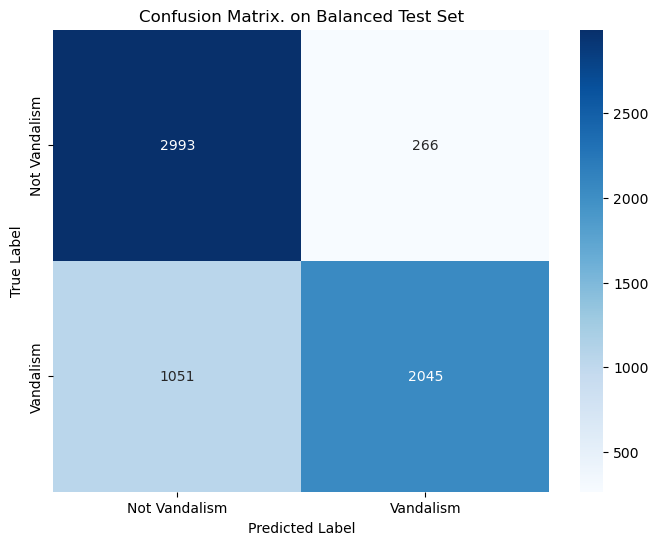

In [43]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_df.isvandalism, y_pred, digits=4))
print(accuracy_score(test_df.isvandalism, y_pred))
print(f1_score(test_df.isvandalism, y_pred))

#heatmap
confmat = confusion_matrix(test_df.isvandalism,y_pred)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Vandalism', 'Vandalism'],
                    yticklabels=['Not Vandalism', 'Vandalism'])
plt.title('Confusion Matrix. on Balanced Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig('Balanaced Confusion Matrix') #uncomment to save
plt.show()

In [44]:
## Imbalanced Test set
testimba_df =  pd.read_csv("../Data/test_imbalanced.csv")
preprocessor(testimba_df)


Classification Report:
              precision    recall  f1-score   support

       False     0.9404    0.7578    0.8393       479
        True     0.1773    0.5208    0.2646        48

    accuracy                         0.7362       527
   macro avg     0.5589    0.6393    0.5519       527
weighted avg     0.8709    0.7362    0.7870       527

0.7362428842504743
0.26455026455026454


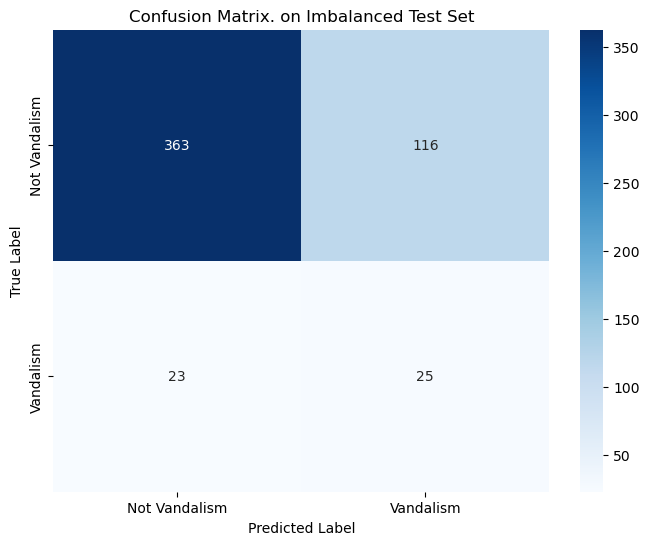

In [45]:
y_predimba = nb_pipe.predict(testimba_df)

# Classification Report
print("\nClassification Report:")
print(classification_report(testimba_df.isvandalism, y_predimba, digits=4))
print(accuracy_score(testimba_df.isvandalism, y_predimba))
print(f1_score(testimba_df.isvandalism, y_predimba))

#heatmap
confmat = confusion_matrix(testimba_df.isvandalism,y_predimba)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Vandalism', 'Vandalism'],
                    yticklabels=['Not Vandalism', 'Vandalism'])
plt.title('Confusion Matrix. on Imbalanced Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.savefig('Imbalanaced Confusion Matrix') #uncomment to save
plt.show()